In [31]:
import tensorflow as tf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utils.layers import Sequential, Zip, Parallel, Linear, ScaleTanh
from utils.dynamics import Dynamics
from utils.func_utils import get_data, binarize, tf_accept

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
path = 'logs/random_mask/optimizer=adam,learning_rate=0.001,latent_dim=50,MH=10,batch_size=512,update_sampler_every=1,leapfrogs=10/model.ckpt'

with tf.gfile.Open(path+'.meta'):
    tf.reset_default_graph()
    tf.train.import_meta_graph(path+'.meta')

In [142]:
tf.reset_default_graph()

In [121]:
node_list = [(n.name, n) for n in tf.get_default_graph().as_graph_def().node if 'Const' in str(n.name)]

In [141]:
mask = tf.get_default_graph().get_tensor_by_name('sampler/Const_%d:0' % 1)

with tf.Session() as sess:
    mask = sess.run(mask)

In [143]:
with tf.variable_scope('encoder'):
    encoder = Sequential([
        Linear(784, 1024, scope='encoder_1'),
        tf.nn.softplus,
        Linear(1024, 1024, scope='encoder_2'),
        tf.nn.softplus,
        Parallel([
            Linear(1024, 50, scope='encoder_mean'),
            Linear(1024, 50, scope='encoder_std'),
        ])
    ])

with tf.variable_scope('decoder'):
    decoder = Sequential([
        Linear(50, 1024, scope='decoder_1'),
        tf.nn.softplus,
        Linear(1024, 1024, scope='decoder_2'),
        tf.nn.softplus,
        Linear(1024, 784, scope='decoder_3', factor=0.01)
    ])

# Setting up the VAE

inp = tf.placeholder(tf.float32, shape=(None, 784))

mu, log_sigma = encoder(inp)

noise = tf.random_normal(tf.shape(mu))

latent_q = mu + noise * tf.exp(log_sigma)

logits = decoder(latent_q)

# Setting up sampler
def energy(z, aux=None):
    logits = decoder(z)
    log_posterior = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=aux, logits=logits), axis=1)
    log_prior = -0.5 * tf.reduce_sum(tf.square(z), axis=1)
    return -log_posterior - log_prior

sampler_loss = 0.

with tf.variable_scope('sampler'):
    size1 = 200
    size2 = 200

    encoder_sampler = Sequential([
        Linear(784, 512, scope='encoder_1'),
        tf.nn.softplus,
        Linear(512, 512, scope='encoder_2'),
        tf.nn.softplus,
        Linear(512, size1, scope='encoder_3'),
    ])

    def net_factory(x_dim, scope, factor):
        with tf.variable_scope(scope):
            net = Sequential([
                Zip([
                    Linear(50, size1, scope='embed_1', factor=0.33),
                    Linear(50, size1, scope='embed_2', factor=factor * 0.33),
                    Linear(2, size1, scope='embed_3', factor=0.33),
                    encoder_sampler,
                ]),
                sum,
                tf.nn.relu,
                Linear(size1, size2, scope='linear_1'),
                tf.nn.relu,
                Parallel([
                    Sequential([
                        Linear(size2, 50, scope='linear_s', factor=0.01), 
                        ScaleTanh(50, scope='scale_s')
                    ]),
                    Linear(size2, 50, scope='linear_t', factor=0.01),
                    Sequential([
                        Linear(size2, 50, scope='linear_f', factor=0.01),
                        ScaleTanh(50, scope='scale_f'),
                    ])
                ])
            ])
        return net

    dynamics = Dynamics(
        50, 
        energy, 
        T=10, 
        eps=0.1, 
        hmc=False, 
        net_factory=net_factory, 
        eps_trainable=True, 
        use_temperature=False,
    )

In [144]:
dynamics.mask = tf.constant(mask, tf.float32)

In [145]:
Z = tf.placeholder(tf.float32, shape=(None, 50))
probs = tf.nn.sigmoid(decoder(Z))
sample = tf.cast((probs - tf.random_uniform(tf.shape(probs)) >= 0), tf.float32)

In [146]:
saver = tf.train.Saver()

sess = tf.Session()

In [147]:
saver.restore(save_path='logs/random_mask/optimizer=adam,learning_rate=0.001,latent_dim=50,MH=10,batch_size=512,update_sampler_every=1,leapfrogs=10/model.ckpt',
             sess=sess)

INFO:tensorflow:Restoring parameters from logs/random_mask/optimizer=adam,learning_rate=0.001,latent_dim=50,MH=10,batch_size=512,update_sampler_every=1,leapfrogs=10/model.ckpt


In [ ]:
z_eval = tf.random_normal((64, 50))
x_eval = tf.nn.sigmoid(decoder(z_eval))

In [148]:
def plot_grid(S, width=8):
    sheet_width = width
    plt.figure(figsize=(8, 8))
    for i in xrange(S.shape[0]):
        plt.subplot(sheet_width, sheet_width, i + 1)
        plt.imshow(S[i], cmap='gray')
        plt.grid('off')
        plt.axis('off')

In [149]:
train, test = get_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [150]:
train = np.reshape(train, (-1, 28, 28))

In [174]:
mask

<tf.Tensor 'Cast_20:0' shape=(?, 1) dtype=float32>

In [173]:
latent = latent_q

for t in range(10):
    mask = tf.cast(tf.random_uniform((tf.shape(latent)[0], 1), maxval=2, dtype=tf.int32), tf.float32)

    Lx1, _, px1 = dynamics.forward(latent, aux=inp)
    Lx2, _, px2 = dynamics.backward(latent, aux=inp)

    Lx = mask * Lx1 + (1 - mask) * Lx2
    px = tf.squeeze(mask, axis=1) * px1 + tf.squeeze(1 - mask, axis=1) * px2

    latent = tf_accept(latent, Lx, px)

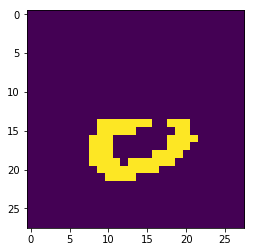

In [175]:
x0 = np.copy(train[66])
x0[:14, :] = 0
x0 = binarize(x0)
plt.imshow(x0)

samples2 = []
curr_sample = np.copy(x0).flatten()[None, :]
for t in range(100):
    current_z = sess.run(latent, {inp: curr_sample})
    # curr_sample = sess.run(sample, {Z: current_z})
    curr_probs = sess.run(probs, {Z: current_z})
    samples2.append(np.copy(curr_probs))

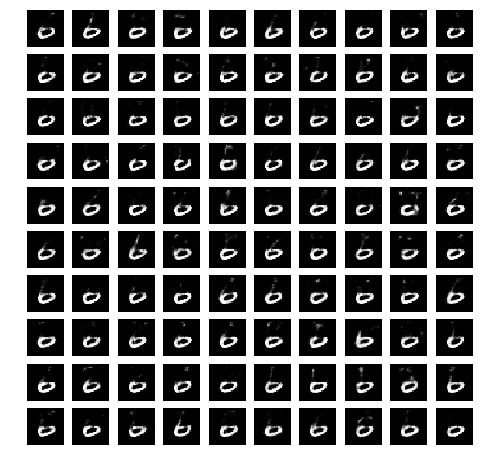

In [176]:
S = np.array(samples2)
S = np.reshape(S, (-1, 28, 28))

plot_grid(S, width=10)

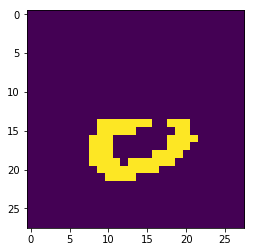

In [177]:
# x0 = np.copy(train[66])
# x0[:14, :] = 0
# x0 = binarize(x0)
plt.imshow(x0)

samples = []
curr_sample = np.copy(x0).flatten()[None, :]
for t in range(100):
    current_z = sess.run(latent_q, {inp: curr_sample})
    # curr_sample = sess.run(sample, {Z: current_z})
    curr_probs = sess.run(probs, {Z: current_z})
    samples.append(np.copy(curr_probs))

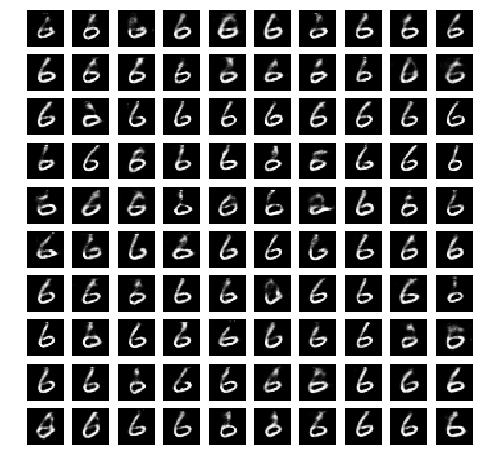

In [178]:
S2 = np.array(samples)
S2 = np.reshape(S2, (-1, 28, 28))

plot_grid(S2, width=10)

In [ ]:
with tf.Session() as sess:
    sess.run([op1, op2], {x1: np.eye(5,), x2: 5 * np.eye(5,)})
    
    time0 = time.time()
    
    [sess.run(op1, {x1: np.eye(5,), x2: 5 * np.eye(5,)}) for t in range(1000)]
    
    time1 = time.time()
    
    [sess.run(op2, {x1: np.eye(5,), x2: 5 * np.eye(5,)}) for t in range(1000)]
    123
    time2 = time.time()